<a href="https://colab.research.google.com/github/gonzakayunawel/tree_n_ensamble_classifier_models/blob/main/titanic_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Classifier: Modelos de Clasificación basados en árboles para el DataSet Titanic

## Importar librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Cargar el dataset y transformar a DataFrame

In [ ]:
df = sns.load_dataset("titanic")

## EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [ ]:
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
missing_percentage = df.isnull().sum().sort_values(ascending=False) / len(df)
print(missing_percentage)

deck           0.772166
age            0.198653
embarked       0.002245
embark_town    0.002245
survived       0.000000
pclass         0.000000
sex            0.000000
sibsp          0.000000
parch          0.000000
fare           0.000000
class          0.000000
who            0.000000
adult_male     0.000000
alive          0.000000
alone          0.000000
dtype: float64


## Preparación de los datos

### Columnas con datos categóricos

In [ ]:
df_categoric_cols = df.select_dtypes(include=['object', 'category'])

### Verificar porcentaje de datos nulos

In [ ]:
missing_percentage_cat_cols = df_categoric_cols.isnull().sum().sort_values(ascending=False) / len(df)
print(missing_percentage_cat_cols)

deck           0.772166
embarked       0.002245
embark_town    0.002245
sex            0.000000
class          0.000000
who            0.000000
alive          0.000000
dtype: float64


### Eliminar columna "deck":
- Su nivel de datos nulos supera el 50% y puede generar una imputación poco realista
- Evitamos añadir ruido a los modelos y disminuir su precisión

In [ ]:
df_categoric_cols = df_categoric_cols.drop(['deck'], axis=1)

### Imputar la moda en las columnas embarked y embark town
- Su nivel de datos nulos es ínfimo y no afecta la imputación

In [ ]:
embarked_mode = df_categoric_cols['embarked'].mode()[0]
embark_town_mode = df_categoric_cols['embark_town'].mode()[0]

In [ ]:
df_categoric_cols['embarked'] = df_categoric_cols['embarked'].fillna(embarked_mode)
df_categoric_cols['embark_town'] = df_categoric_cols['embark_town'].fillna(embark_town_mode)

In [ ]:
missing_percentage_cat_cols = df_categoric_cols.isnull().sum().sort_values(ascending=False) / len(df)
print(missing_percentage_cat_cols)

sex            0.0
embarked       0.0
class          0.0
who            0.0
embark_town    0.0
alive          0.0
dtype: float64


### Columnas con datos numéricos

In [ ]:
df_numeric_cols = df.select_dtypes(include=['float64', 'int64', 'bool'])

In [ ]:
missing_percentage_num_cols = df_numeric_cols.isnull().sum().sort_values(ascending=False) / len(df_numeric_cols)
print(missing_percentage_num_cols)

age           0.198653
survived      0.000000
pclass        0.000000
sibsp         0.000000
parch         0.000000
fare          0.000000
adult_male    0.000000
alone         0.000000
dtype: float64


### Imputar columna age

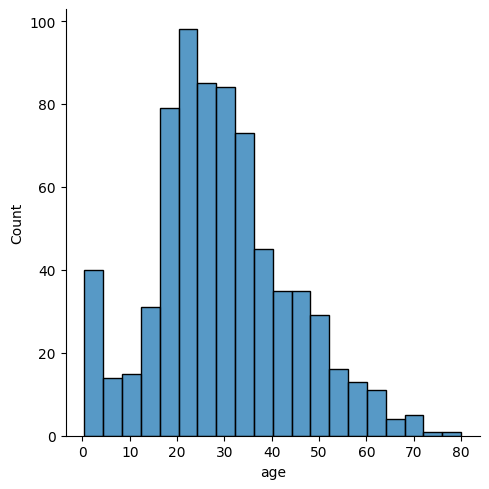

In [ ]:
sns.displot(df_numeric_cols['age'])
plt.show()

### Separar las filas que tienen datos nulos del dataframe

In [ ]:
df_num_cols_with_nans = df_numeric_cols[df_numeric_cols.isnull().any(axis=1)]

In [ ]:
df_num_cols_with_nans.isnull().sum()

survived        0
pclass          0
age           177
sibsp           0
parch           0
fare            0
adult_male      0
alone           0
dtype: int64

### Imputar la columna age usando los valores únicos y su proporción en el dataframe, para imputar datos basados en la distribución original de los datos

In [ ]:
np.random.seed(42)

a = df_numeric_cols["age"].value_counts().index
p = df_numeric_cols["age"].value_counts(normalize=True).values
size = df_num_cols_with_nans.shape[0]

df_num_cols_with_nans['age'] = np.random.choice(a=a, size=size, p=p)

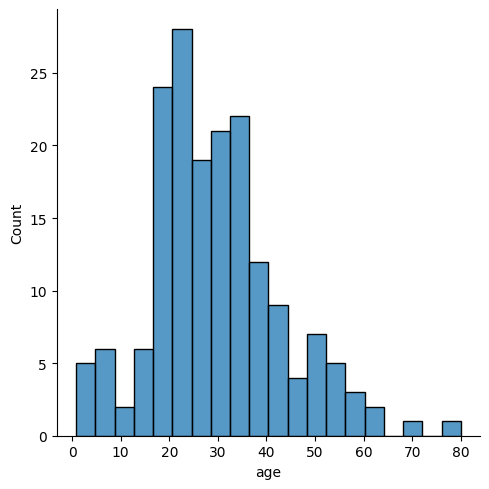

In [ ]:
sns.displot(df_num_cols_with_nans['age'], bins=20)
plt.show()

### Reincorporar el dataframe de filas imputadas al dataframe de datos numéricos

In [ ]:
df_numeric_cols.update(df_num_cols_with_nans)

missing_percentage_num_cols = df_numeric_cols.isnull().sum().sort_values(ascending=False) / len(df_numeric_cols)
print(missing_percentage_num_cols)

survived      0.0
pclass        0.0
age           0.0
sibsp         0.0
parch         0.0
fare          0.0
adult_male    0.0
alone         0.0
dtype: float64


### Codificar las columnas categóricas

In [ ]:
df_categoric_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   sex          891 non-null    object  
 1   embarked     891 non-null    object  
 2   class        891 non-null    category
 3   who          891 non-null    object  
 4   embark_town  891 non-null    object  
 5   alive        891 non-null    object  
dtypes: category(1), object(5)
memory usage: 35.9+ KB


In [ ]:
df_categoric_cols = df_categoric_cols.drop(['alive'], axis=1)

In [ ]:
df_categoric_cols.columns

Index(['sex', 'embarked', 'class', 'who', 'embark_town'], dtype='object')

### Codificar las columnas categóricas nominales

In [ ]:
cols_to_encode_nominal = ['sex', 'embarked', 'who', 'embark_town']

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first', sparse=False)

encoded_data = encoder.fit_transform(df_categoric_cols[cols_to_encode_nominal])

encoded_columns = encoder.get_feature_names_out(cols_to_encode_nominal)

df_categoric_nominal_cols = pd.DataFrame(encoded_data, columns=encoded_columns)

In [ ]:
df_categoric_nominal_cols.sample(10)

,sex_male,embarked_Q,embarked_S,who_man,who_woman,embark_town_Queenstown,embark_town_Southampton
791,1.0,0.0,1.0,1.0,0.0,0.0,1.0
123,0.0,0.0,1.0,0.0,1.0,0.0,1.0
290,0.0,0.0,1.0,0.0,1.0,0.0,1.0
844,1.0,0.0,1.0,1.0,0.0,0.0,1.0
333,1.0,0.0,1.0,1.0,0.0,0.0,1.0
109,0.0,1.0,0.0,0.0,1.0,1.0,0.0
527,1.0,0.0,1.0,1.0,0.0,0.0,1.0
56,0.0,0.0,1.0,0.0,1.0,0.0,1.0
755,1.0,0.0,1.0,0.0,0.0,0.0,1.0
240,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Codificar las columnas categóricas ordinales

In [ ]:
classes = list(df_categoric_cols['class'].unique().astype(str))

In [ ]:
classes

['Third', 'First', 'Second']

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

classes = df_categoric_cols['class'].unique()

ordinal_encoder = OrdinalEncoder(categories=[classes])

encoded_data = ordinal_encoder.fit_transform(df_categoric_cols[['class']])

encoded_cat_ord_data_df = pd.DataFrame(encoded_data, columns=['class_encoded'])

### Incorporar las columnas categóricas codificadas en un solo dataframe

In [ ]:
df_encoded_cols = df_categoric_nominal_cols
df_encoded_cols['class_encoded'] = encoded_cat_ord_data_df

In [ ]:
df_encoded_cols.sample(10)

,sex_male,embarked_Q,embarked_S,who_man,who_woman,embark_town_Queenstown,embark_town_Southampton,class_encoded
212,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
774,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0
188,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
429,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
595,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
655,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0
498,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
563,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
821,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


### Unir el dataframe numérico con el dataframe categórico

In [ ]:
df_titanic = pd.concat([df_numeric_cols, df_encoded_cols], axis=1)

In [ ]:
df_titanic.sample(frac=0.07)

,survived,pclass,age,sibsp,parch,fare,adult_male,alone,sex_male,embarked_Q,embarked_S,who_man,who_woman,embark_town_Queenstown,embark_town_Southampton,class_encoded
167,0,3,45.0,1,4,27.9000,False,False,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
269,1,1,35.0,0,0,135.6333,False,True,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
437,1,2,24.0,2,3,18.7500,False,False,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0
295,0,1,18.0,0,0,27.7208,True,True,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8,1,3,27.0,0,2,11.1333,False,False,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,0,2,30.0,0,0,13.0000,True,True,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0
603,0,3,44.0,0,0,8.0500,True,True,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
771,0,3,48.0,0,0,7.8542,True,True,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
738,0,3,8.0,0,0,7.8958,True,True,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
df_titanic.head(15)

,survived,pclass,age,sibsp,parch,fare,adult_male,alone,sex_male,embarked_Q,embarked_S,who_man,who_woman,embark_town_Queenstown,embark_town_Southampton,class_encoded
0,0,3,22.0,1,0,7.2500,True,False,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,1,1,38.0,1,0,71.2833,False,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1,3,26.0,0,0,7.9250,False,True,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1,1,35.0,1,0,53.1000,False,False,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
4,0,3,35.0,0,0,8.0500,True,True,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
5,0,3,35.0,0,0,8.4583,True,True,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
6,0,1,54.0,0,0,51.8625,True,True,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
7,0,3,2.0,3,1,21.0750,False,False,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
8,1,3,27.0,0,2,11.1333,False,False,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
9,1,2,14.0,1,0,30.0708,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


### Cambiar los tipos de datos a Float

In [ ]:
df_titanic[['survived', 'pclass', 'sibsp', 'parch', 'adult_male', 'alone']] = df_titanic[['survived', 'pclass', 'sibsp', 'parch', 'adult_male', 'alone']].astype(float)

In [ ]:
df_titanic

,survived,pclass,age,sibsp,parch,fare,adult_male,alone,sex_male,embarked_Q,embarked_S,who_man,who_woman,embark_town_Queenstown,embark_town_Southampton,class_encoded
0,0.0,3.0,22.0,1.0,0.0,7.2500,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,1.0,1.0,38.0,1.0,0.0,71.2833,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.0,3.0,26.0,0.0,0.0,7.9250,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
4,0.0,3.0,35.0,0.0,0.0,8.0500,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,2.0,27.0,0.0,0.0,13.0000,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0
887,1.0,1.0,19.0,0.0,0.0,30.0000,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
888,0.0,3.0,50.0,1.0,2.0,23.4500,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
889,1.0,1.0,26.0,0.0,0.0,30.0000,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Separar los datos del dataframe entre datos de entranmiento y prueba y definir la variable objetivo

In [ ]:
from sklearn.model_selection import train_test_split

X = df_titanic.drop('survived', axis=1)
y = df_titanic['survived']

test_size_split = 0.25

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_split, random_state=42)

### Función para medir el error

Interpretación de la AUC:
- AUC = 1.0: El modelo tiene una capacidad perfecta para distinguir entre las clases positivas y negativas.
- 0.5 < AUC < 1.0: El modelo tiene alguna capacidad de distinguir entre las clases positivas y negativas. Cuanto más cerca de 1.0, mejor.
- AUC = 0.5: El modelo no tiene capacidad discriminativa, equivalente a hacer predicciones aleatorias.
- AUC < 0.5: El modelo tiene una capacidad peor que el azar para distinguir entre las clases (rara vez ocurre en la práctica, ya que un modelo con AUC < 0.5 puede invertirse para obtener AUC > 0.5).

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score

def model_eval_cross_validation(model, model_name):
    scoring = {
        'accuracy': 'accuracy',
        'f1': make_scorer(f1_score),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)

    print(f"{model_name} -> Accuracy: {scores['test_accuracy'].mean():.4f} ± {scores['test_accuracy'].std():.4f}")
    print(f"{model_name} -> F1 Score: {scores['test_f1'].mean():.4f} ± {scores['test_f1'].std():.4f}")
    print(f"{model_name} -> ROC AUC: {scores['test_roc_auc'].mean():.4f} ± {scores['test_roc_auc'].std():.4f}")
    print("\n")

## Modelos de Clasficación

### Decission Tree Classifier

Decission Tree Classifier -> Accuracy: 0.7856 ± 0.0202
Decission Tree Classifier -> F1 Score: 0.7224 ± 0.0191
Decission Tree Classifier -> ROC AUC: 0.7780 ± 0.0181




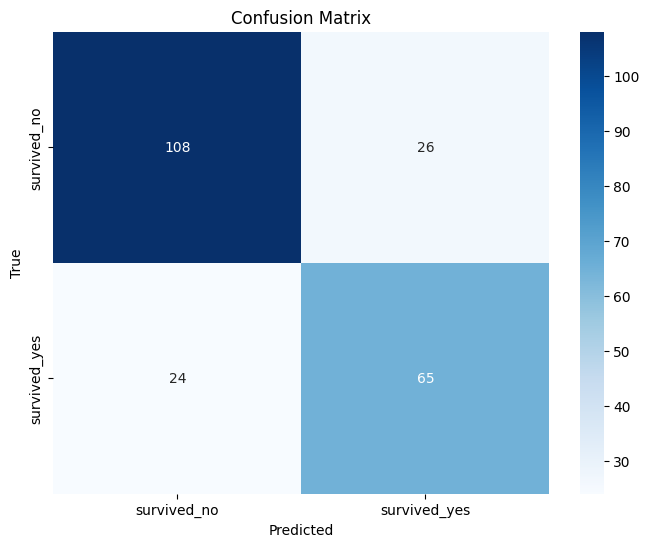

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix


tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

y_pred_proba_tree_clf = tree_clf.predict_proba(X_test)[:,1]
y_pred_tree_clf = tree_clf.predict(X_test)

model_name = 'Decission Tree Classifier'
model_eval_cross_validation(tree_clf, model_name)

labels = ['survived_no', 'survived_yes']
cm_tc = confusion_matrix(y_test, y_pred_tree_clf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tc, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Random Forest Classifier

Random Forest Classifier -> Accuracy: 0.8125 ± 0.0205
Random Forest Classifier -> F1 Score: 0.7508 ± 0.0300
Random Forest Classifier -> ROC AUC: 0.8761 ± 0.0227




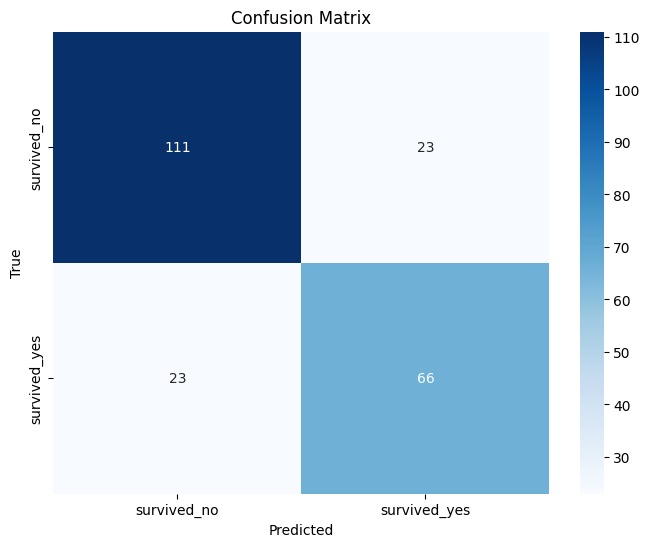

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest_clf = RandomForestClassifier()
random_forest_clf.fit(X_train, y_train)

y_pred_proba_random_forest_clf = random_forest_clf.predict_proba(X_test)[:,1]
y_pred_random_forest_clf = random_forest_clf.predict(X_test)

model_name = 'Random Forest Classifier'
model_eval_cross_validation(random_forest_clf, model_name)


labels = ['survived_no', 'survived_yes']
cm_rfc = confusion_matrix(y_test, y_pred_random_forest_clf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rfc, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### AdaBoost Classifier

AdaBoost Classifier -> Accuracy: 0.8227 ± 0.0146
AdaBoost Classifier -> F1 Score: 0.7680 ± 0.0212
AdaBoost Classifier -> ROC AUC: 0.8633 ± 0.0170




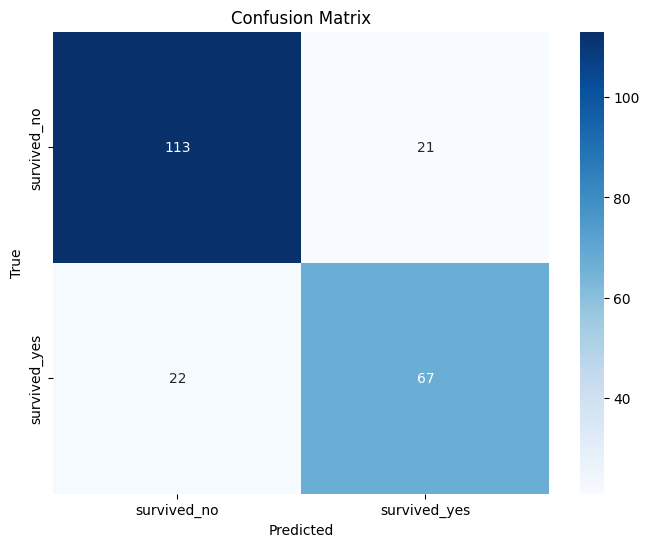

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
ada_clf.fit(X_train, y_train)

y_pred_proba_ada_clf = ada_clf.predict_proba(X_test)[:,1]
y_pred_ada_clf = ada_clf.predict(X_test)

model_name = 'AdaBoost Classifier'
model_eval_cross_validation(ada_clf, model_name)

labels = ['survived_no', 'survived_yes']
cm_adabc = confusion_matrix(y_test, y_pred_ada_clf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_adabc, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### XGBoost Classifier

XGBoost Classifier -> Accuracy: 0.8260 ± 0.0266
XGBoost Classifier -> F1 Score: 0.7675 ± 0.0353
XGBoost Classifier -> ROC AUC: 0.8754 ± 0.0280




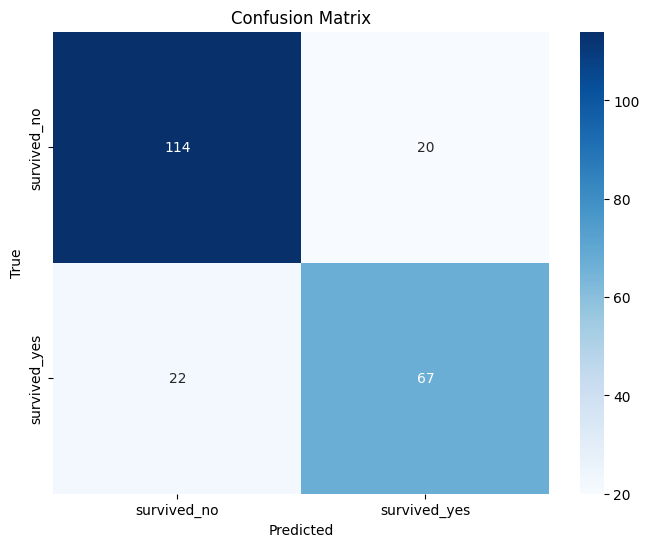

In [ ]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(n_estimators=50, random_state=42)

xgb_clf.fit(X_train, y_train)

y_pred_proba_xgb_clf = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_xgb_clf = xgb_clf.predict(X_test)

model_name = 'XGBoost Classifier'
model_eval_cross_validation(xgb_clf, model_name)

labels = ['survived_no', 'survived_yes']
cm_xgbc = confusion_matrix(y_test, y_pred_xgb_clf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgbc, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### HistGradientBoost Classifier (LightGBM)

HistGradientBoost Classifier -> Accuracy: 0.8316 ± 0.0205
HistGradientBoost Classifier -> F1 Score: 0.7703 ± 0.0296
HistGradientBoost Classifier -> ROC AUC: 0.8814 ± 0.0231




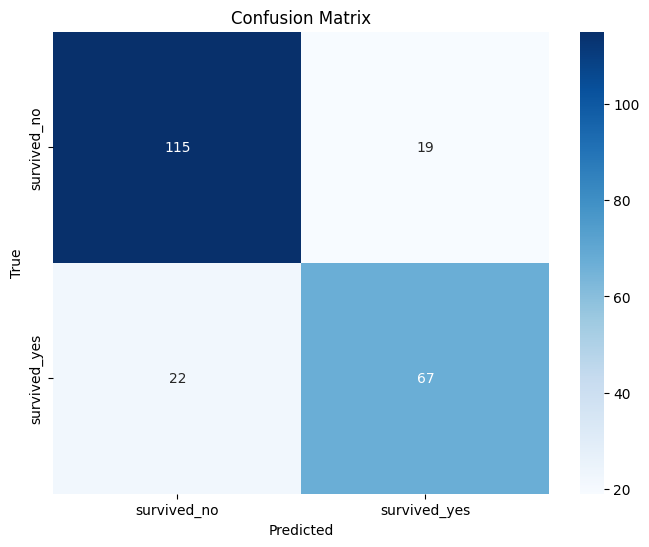

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb_clf = HistGradientBoostingClassifier()
hgb_clf.fit(X_train, y_train)

y_pred_proba_hgb_clf = hgb_clf.predict_proba(X_test)[:, 1]
y_pred_hgb_clf = hgb_clf.predict(X_test)

model_name = 'HistGradientBoost Classifier'
model_eval_cross_validation(hgb_clf, model_name)


labels = ['survived_no', 'survived_yes']
cm_hgbc = confusion_matrix(y_test, y_pred_hgb_clf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_hgbc, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()